In [1]:
import pandas as pd
import cv2
import os
import numpy as np
from tqdm import tqdm, trange

#hs
import datetime
import matplotlib.pyplot as plt
import numpy as np
import utils as utl

# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# hs loading Model for inference using saved weights

In [2]:
from hs_config import HsConfig
from bowl_dataset import BowlDataset
import hsModel as modellib
import functions as f


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        512
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0005
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               512
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           hsConfig
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINI

Using TensorFlow backend.


In [3]:
# Override the training config (hsConfig) with a few
# changes for inferencing.
class HsInferenceConfig(HsConfig):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
#    RESNET_ARCHITECTURE = "resnet50"

hs_inference_config = HsInferenceConfig()
hs_inference_config.display()


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        512
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0005
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               512
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           hsConfig
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINI

In [4]:
ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [5]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=hs_inference_config,
                          model_dir=MODEL_DIR)

In [11]:
# Get path to saved weights
# Either set a specific path or find last trained weights
#model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()[1]


model_path = os.path.join(MODEL_DIR, 'maskRCNN_Resnet101_ep25_apha0001_weightDecay001_score.h5')

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/hooman67/Cell_Nuclei_Segmentation/kaggle-ds-bowl-2018-baseline/logs/maskRCNN_Resnet101_ep25_apha0001_weightDecay001_score.h5


# hs calculating competition score on Training set

In [7]:
hsDataset = BowlDataset()
hsDataset.load_bowl('stage1_train')
hsDataset.prepare()

In [ ]:
# hs calculate mAP score for all images
badImages = [118, 136, 237, 268, 291, 300, 458, 506, 541]
totalAverageScore = 0;
counter = 0

for imIdIndex in trange(len(hsDataset.image_ids)):
    if imIdIndex not in badImages:
        gt_image, gt_image_meta, gt_class_ids, gt_bbox, gt_masks = modellib.load_image_gt(hsDataset, hs_inference_config, imIdIndex)

        resultsList = model.detect([gt_image], verbose=0)
        resultsDict = resultsList[0]

        im_mAP,_,_,_ = utl.compute_ap(gt_bbox,
                                    gt_class_ids,
                                    gt_masks,
                                    resultsDict['rois'],
                                    resultsDict['class_ids'],
                                    resultsDict['scores'],
                                    resultsDict['masks'],
                                    iou_threshold=0.5
                                   )

        totalAverageScore += im_mAP
        counter += 1
    
totalAverageScore = totalAverageScore / counter
print(totalAverageScore)

 75%|███████▌  | 498/664 [09:34<03:11,  1.15s/it]

#### HS Results:
maskRCNN_Resnet101_ep25_apha0005_weightDecay001_score:
<br>
maskRCNN_Resnet101_ep25_apha0001_weightDecay001_score:
<br>
maskRCNN_Resnet101_ep26_apha0005_weightDecay0007_score373:0.904134451009
<br>
maskRCNN_Resnet101_ep24_apha001_weightDecay0007_score396: 0.909014679019
<br>
totalAverageScore = 0.20451001118  for mask rcnn 1 epoch 
<br>
totalAverageScore = 0.379581637458 for mask rcnn 70 epoch

# hs Generating Submission file on test set

In [7]:
#Hs this perform predictions and creates submission csv file.
output = []
sample_submission = pd.read_csv('stage1_sample_submission.csv')
ImageId = []
EncodedPixels = []


for image_id in tqdm(sample_submission.ImageId):
    image_path = os.path.join('stage1_test', image_id, 'images', image_id + '.png')
    
    original_image = cv2.imread(image_path)
    results = model.detect([original_image], verbose=0)
    r = results[0]
    
    masks = r['masks']
    ImageId_batch, EncodedPixels_batch = f.numpy2encoding_no_overlap2(masks, image_id, r['scores'])
    ImageId += ImageId_batch
    EncodedPixels += EncodedPixels_batch
    
f.write2csv('subm17_maskRCNN_resNet101_at25Ep_lr0001_WD001_score.csv', ImageId, EncodedPixels)
#f.write2csv('subm_maskRcnn_' + str(datetime.datetime.now()) + '.csv', ImageId, EncodedPixels)

100%|██████████| 65/65 [00:41<00:00,  1.55it/s]


# hs Debugging Submission file

Pandas pd.read_csv returns a dataFrame object:
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.from_csv.html

Look here for the fields and methods avaiable in DataFrame class:
https://pandas.pydata.org/pandas-docs/stable/api.html#dataframe

pandas.DataFrame is a csv file basically with column headers and rows and columns. 
pandas.Series is the data structure for a single column of a DataFrame.
i.e. the data in a DataFrame is actually stored in memory as a collection of Series.

Ex. Attribute: df.shape  returns shape
Ex. Method: DataFrame.head([n])	Returns the first n rows.

Indexing notice: 
You can index into the dataframe using [] in different ways: 
    1. df.SomeColumnName[row#]  returns you a single literal. (ex. df.ImageId[50] returns a string)
    2. df.SomeColumnName[row#A : row#B] returns you a series object (a column) containing the rows
       you requested. including row#A excluding row#B. So   df.SomeColumnName[row#A : row#A] returns 
       you an empty series object.
    3. df[row#A : row#B] returns a DataFrame object containing the rows requested an all the columns. 
       df[row#A : row#A] returns an empty DataFrame object.
    4. db[row#A] is a syntax error because [row#] cannot return a literal, and objects are returned 
    only when [] recieves a range due to overloading. 
    
    df.shape   
        (1885, 2)
    
    df.ImageId[50]
        '0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac'
    type(df.ImageId[50])
        str
    
    df.ImageId[50:51]
        50    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...
        Name: ImageId, dtype: object
    type(df.ImageId[50:51])
        pandas.core.series.Series
    
    df[50:51]
        ImageId	                                                EncodedPixels
        50	0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...	2252 14 2771 15 3290 15 3808...
    type(df[50:51])
        pandas.core.frame.DataFrame
    df[50]
        !!!Syntax error!!!

    df.ImageId.unique()  
        Uniques are returned in order of appearance. This does NOT sort.
    type(df.ImageId.unique())
        numpy.ndarray
    df.ImageId.unique()[50:51]
        array(['bdc789019cee8ddfae20d5f769299993b4b330b2d38d1218646cf89e77fbbd4d'], dtype=object)
    type(df.ImageId.unique()[50:51])
        numpy.ndarray

In [12]:
def test_image(df, image_id, plot=False):
    image = cv2.imread('stage1_test/' + image_id + '/images/' + image_id + '.png')
    shape = image.shape[:2]  # image.shape == (519, 253, 3)
    #hs since rle_decode takes a string, df.EncodedPixels[df.ImageId == image_id] would work in below too.
    for rle in df[df.ImageId == image_id].EncodedPixels:
        try:
            decoded_result = utl.rle_decode(rle, shape)
            plt.figure()
            plt.imshow(image)
            plt.figure()
            plt.imshow(decoded_result)
        except Exception as e:
            print(e)
            print(image_id)
            print('---')

In [13]:
df = pd.read_csv('submission_v2.csv')
df.head()

,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,45104 7 45358 9 45614 9 45870 9 46126 9 46382 ...
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50539 2 50787 11 51043 11 51299 12 51555 11 51...
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,10886 11 11142 11 11398 12 11654 12 11909 13 1...
3,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,38815 9 39071 10 39326 11 39582 11 39838 11 40...
4,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,51859 8 52115 9 52371 9 52627 9 52883 9 53138 ...


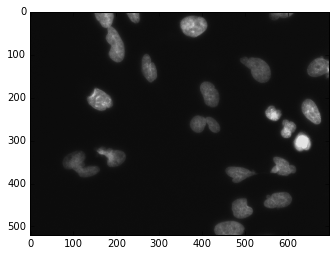

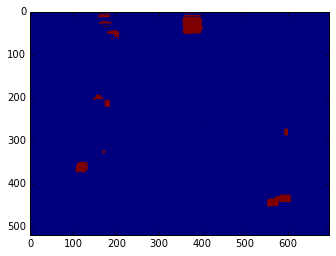

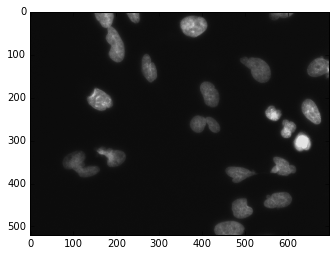

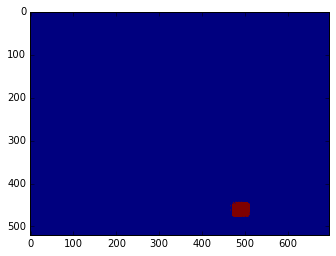

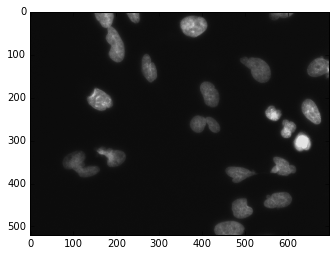

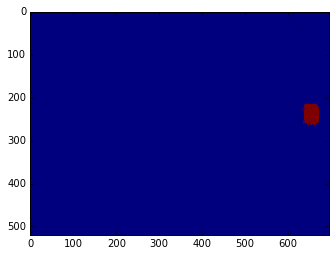

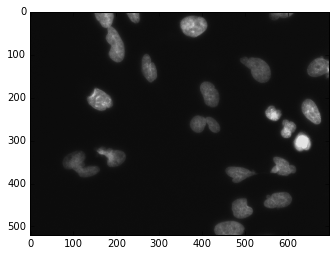

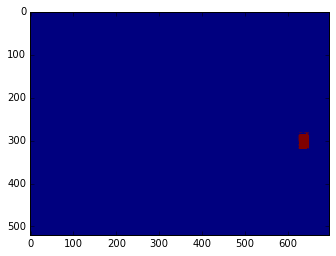

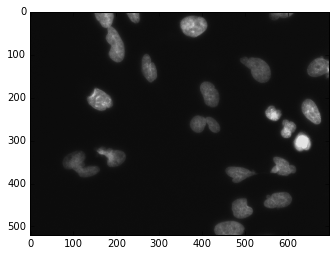

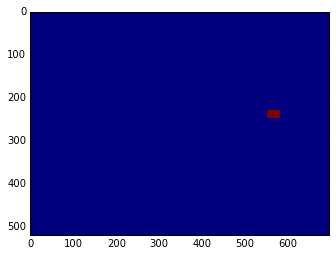

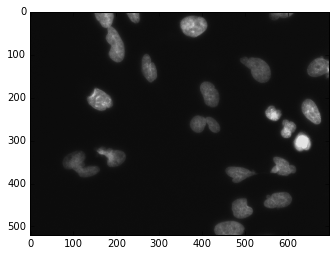

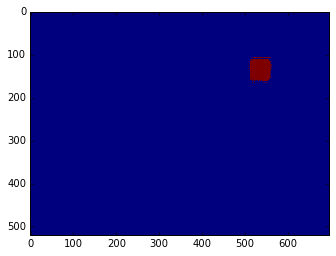

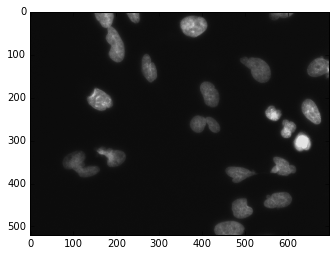

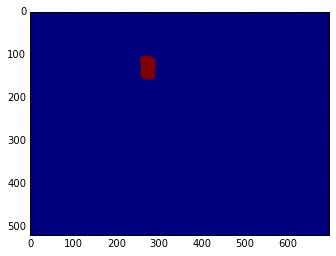

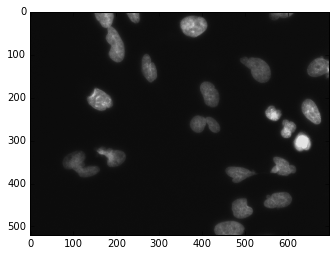

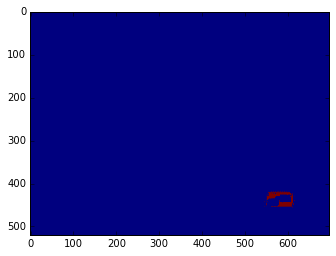

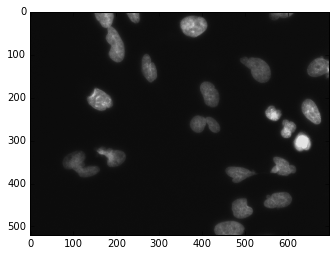

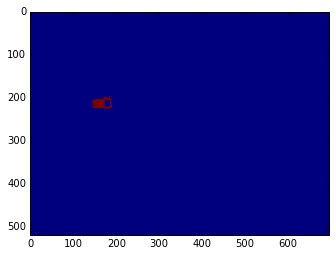

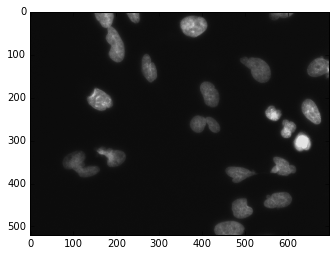

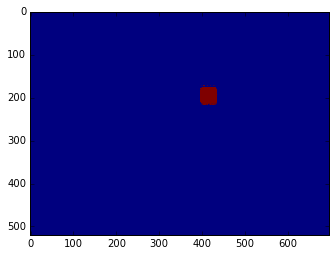

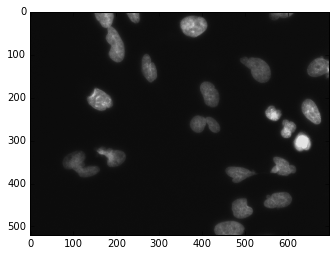

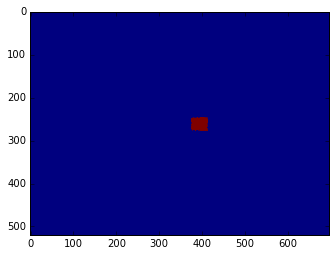

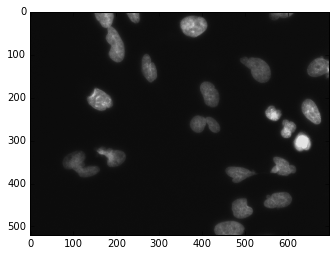

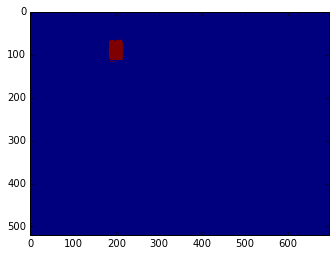

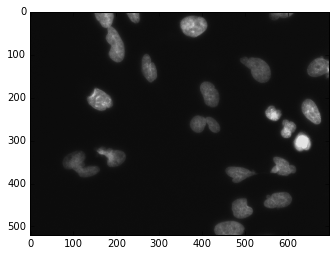

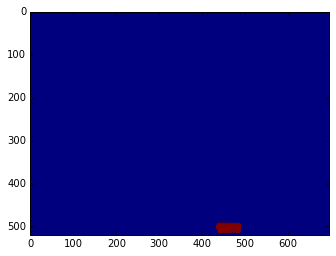

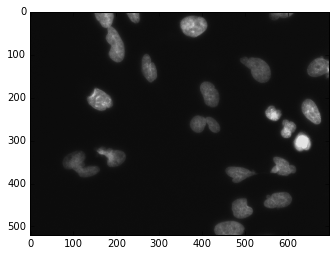

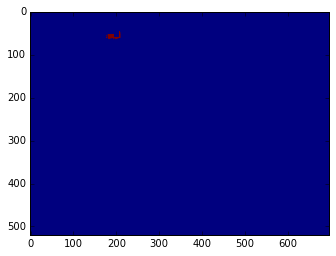

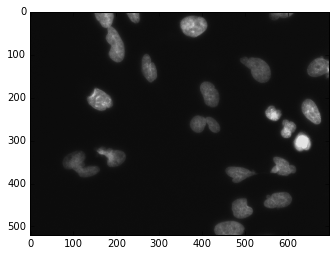

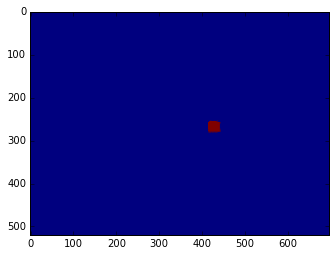

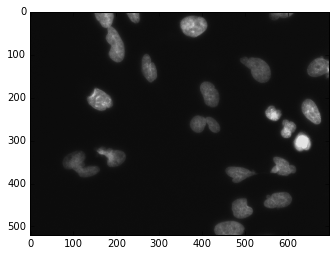

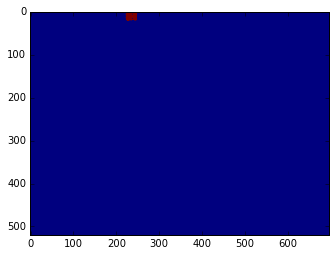

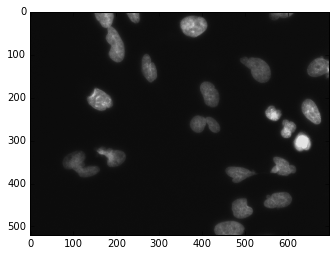

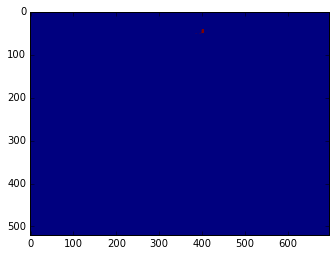

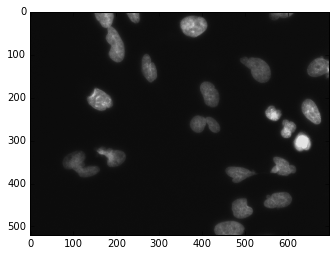

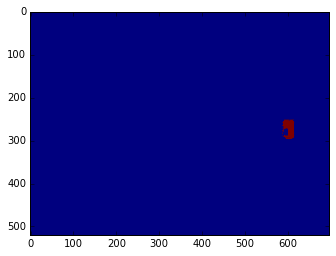

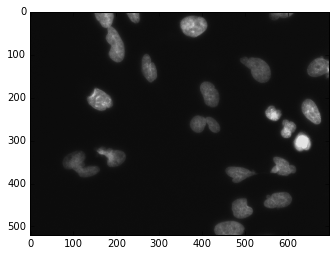

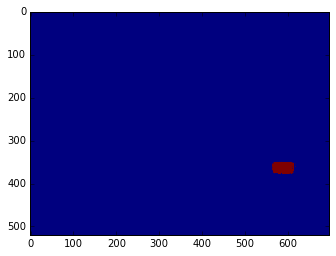

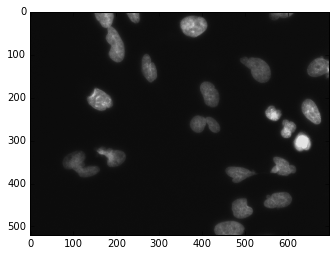

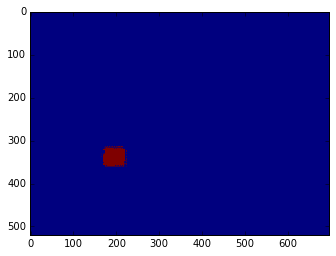

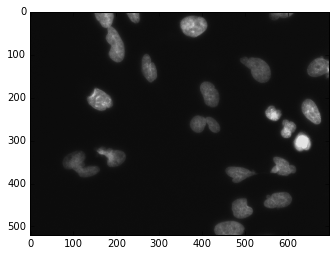

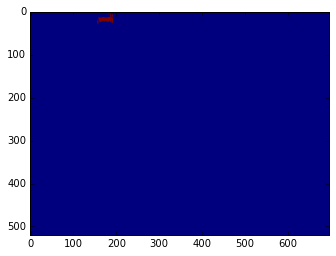

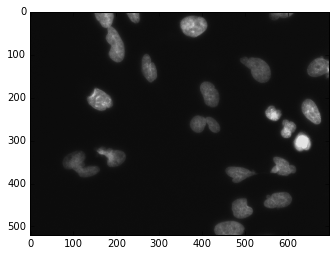

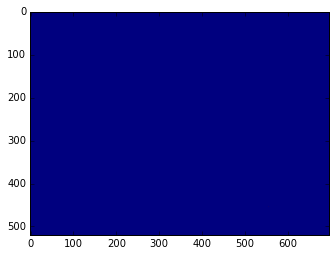

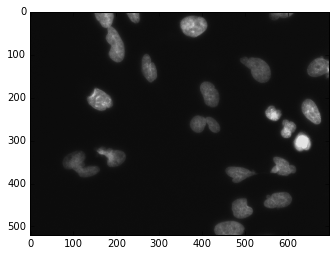

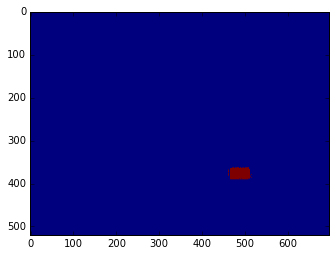

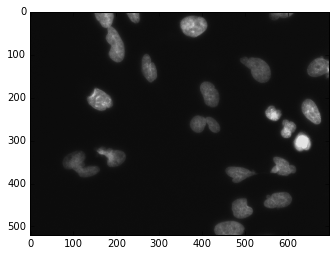

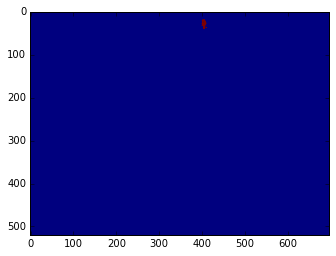

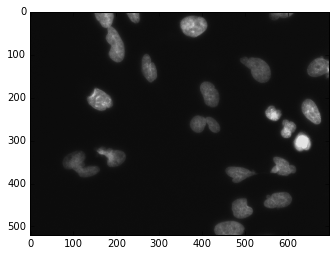

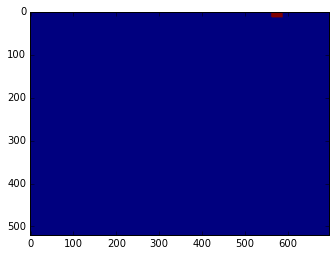

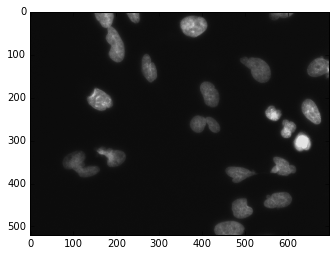

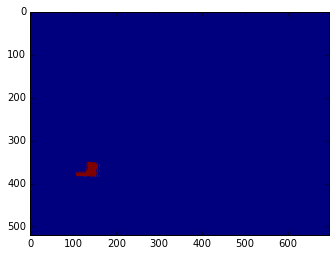

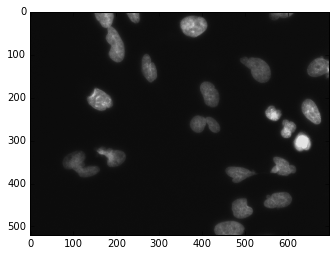

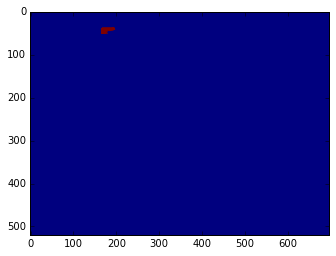

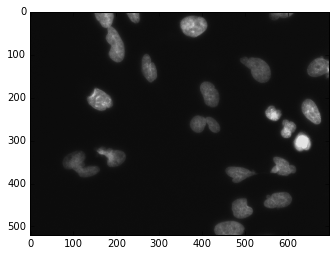

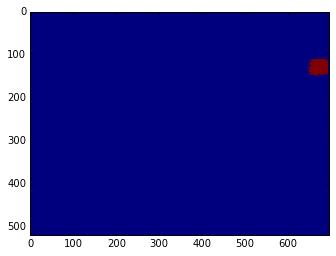

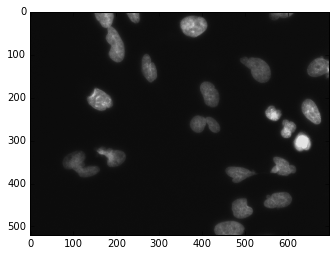

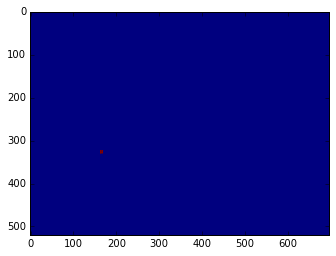

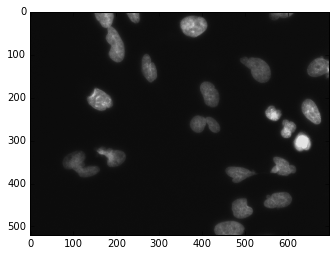

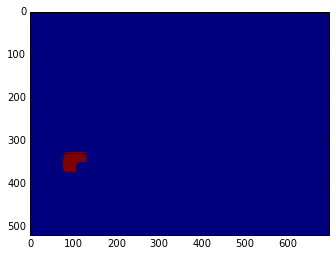

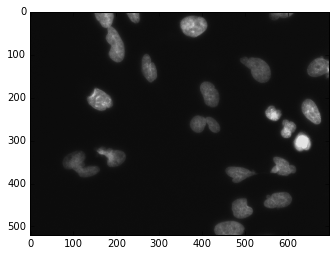

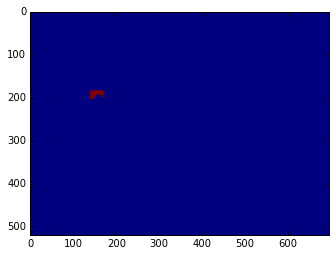

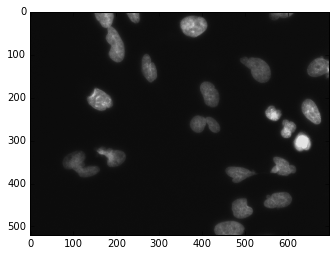

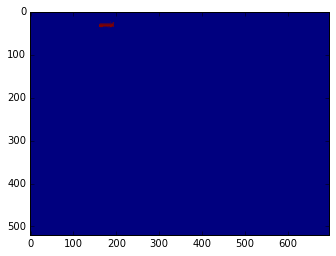

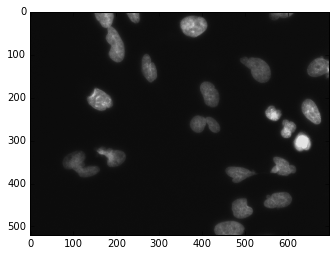

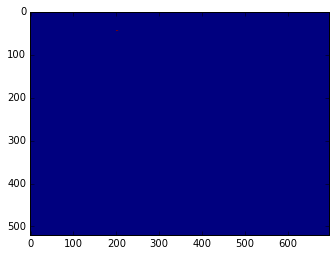

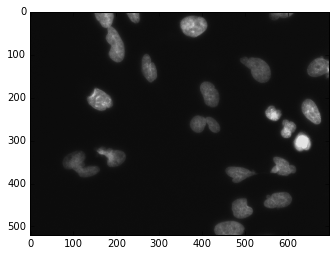

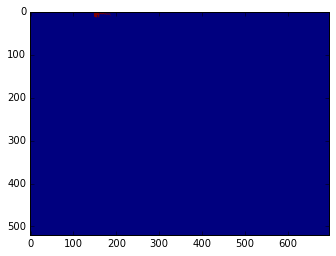

In [14]:
for image_id in df.ImageId.unique()[50:51]:
    test_image(df, image_id)

# Research

0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac


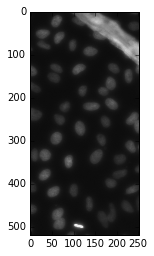

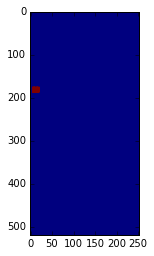

In [16]:
# hs read a single image. Note that you could've used df.ImageId[50] i just wanted to get the same image as below.
hsImageId = df.ImageId[50] #df.ImageId.unique()[50] 
print(hsImageId)
image = cv2.imread('stage1_test/' + hsImageId + '/images/' + hsImageId + '.png')
plt.figure()
plt.imshow(image)


#hs read a single mask
hsRunLengthEncodedMask = df.EncodedPixels[50]
decodedMask = utl.rle_decode(hsRunLengthEncodedMask, image.shape[:2])  #  image.shape == (519, 253, 3)
plt.figure()
plt.imshow(decodedMask)

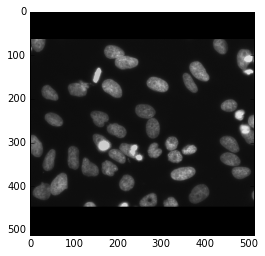

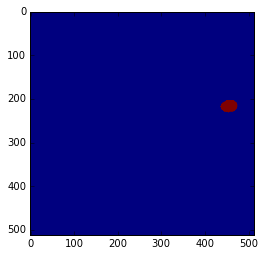

In [17]:
#hs this loads the ground truth for 1 training example. Methos is in model.py
# hs_mask contains the masks for all the object in the image. 
# hs_image.shape     == (512, 512, 3)
# hs_masks.shape     == (512, 512, 28)
# hs_bbox.shape      == (28, 4)
# hs_class_ids.shape == (28,)
hs_image, hs_image_meta, hs_class_ids, hs_bbox, hs_masks = modellib.load_image_gt(hsDataset, bowl_config, 50)
plt.figure()
plt.imshow(hs_image)
plt.figure()
plt.imshow(hs_masks[:,:,27])

In [18]:
# hs thsi performs predictions and stores the results in r.
results = model.detect([hs_image], verbose=0)
r = results[0]
r.keys()

dict_keys(['class_ids', 'rois', 'masks', 'scores'])

In [20]:
# this calculates the score 
"""
def compute_ap(gt_boxes, gt_class_ids, gt_masks,
               pred_boxes, pred_class_ids, pred_scores, pred_masks,
               iou_threshold=0.5):

    Compute Average Precision at a set IoU threshold (default 0.5).

    Returns:
    mAP: Mean Average Precision
    precisions: List of precisions at different class score thresholds.
    recalls: List of recall values at different class score thresholds.
    overlaps: [pred_boxes, gt_boxes] IoU overlaps.
"""

hs_mAP, hs_precisions, hs_recalls, hs_overlaps = utl.compute_ap(
    hs_bbox, hs_class_ids, 
    hs_masks, r['rois'], 
    r['class_ids'], 
    r['scores'], 
    r['masks'], 
    iou_threshold=0.5
)
print(hs_mAP)

0.804237829704
